In [1]:
# imports
import cv2 # opencv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from dataset_generator import get_waldorf_statler_mfcc_features, create_pig_image_dataset, create_swedish_chef_image_dataset

import tensorflow as tf
from tensorflow import keras

# definitons of constants/variables
video_file_glob_path = '../../videos/*.avi'
audio_base_path = '../../audio/'
pig_data_path = '../../ground_truth/pig/'
pig_keras_path = '../../ground_truth/pig_keras/'
pig_label_file = pig_data_path + 'labels.txt'
swedish_chef_data_path = '../../ground_truth/swedish_chef/'
swedish_chef_keras_path = '../../ground_truth/swedish_chef_keras/'
swedish_chef_label_file = swedish_chef_data_path + 'labels.txt'
evaluation_base_path = '../../evaluation/'

label_map = {0: 'kermit_the_frog',
             1: 'waldorf_and_statler',
             2: 'pig',
             3: 'swedish_chef',
             4: 'none'}

In [2]:
def load_pig_image_dataset():
    data = pd.DataFrame([], columns=['name', 'file_id', 'filename', 'contains_character'])

    with open(pig_label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = pig_data_path + name + '_' + splits[2] + '.jpg'
            data = data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'contains_character': 1 if 2 in labels else 0}, ignore_index=True)
    return data

def load_swedish_chef_image_dataset():
    data = pd.DataFrame([], columns=['name', 'file_id', 'filename', 'contains_character'])

    with open(swedish_chef_label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = swedish_chef_data_path + name + '_' + splits[2] + '.jpg'
            data = data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'contains_character': 1 if 3 in labels else 0}, ignore_index=True)
    return data


def train_test_validation_split(df):
    video1_df = df[df['file_id'] == 1]
    video2_df = df[df['file_id'] == 2]
    video3_df = df[df['file_id'] == 3]
    
    train_v1_df, test_v1_df, val_v1_df = np.split(video1_df.sample(frac=1, random_state=42), [int(.6*len(video1_df)), int(.8*len(video1_df))])
    train_v2_df, test_v2_df, val_v2_df = np.split(video2_df.sample(frac=1, random_state=42), [int(.6*len(video2_df)), int(.8*len(video2_df))]) 
    train_v3_df, test_v3_df, val_v3_df = np.split(video3_df.sample(frac=1, random_state=42), [int(.6*len(video3_df)), int(.8*len(video3_df))]) 
    
    train_df = pd.concat([train_v1_df, train_v2_df, train_v3_df]).reset_index(drop=True)
    test_df = pd.concat([test_v1_df, test_v2_df, test_v3_df]).reset_index(drop=True)
    val_df = pd.concat([val_v1_df, val_v2_df, val_v3_df]).reset_index(drop=True)
    
    return train_df, test_df, val_df


In [3]:
# create pig and swedish set image dataset if not exists (this is checked by the function itself)
create_pig_image_dataset()
create_swedish_chef_image_dataset()

# after dataset creation, load it into dataframe
df_pig = load_pig_image_dataset()
df_swedish_chef = load_swedish_chef_image_dataset()

Kermit image dataset already created.
Kermit image dataset already created.


In [4]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.15,
    zoom_range=0.2,
    rotation_range=15,
    horizontal_flip=True,
    validation_split=0.2)

df_pig['contains_character'] = df_pig['contains_character'].astype('str') # needed due to class_mode=binary

train_pig = data_generator.flow_from_dataframe(
    df_pig,
    x_col='filename',
    y_col='contains_character',
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    subset='training')

test_pig = data_generator.flow_from_dataframe(
    df_pig,
    x_col='filename',
    y_col='contains_character',
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    subset='validation')

Found 2483 validated image filenames belonging to 2 classes.
Found 620 validated image filenames belonging to 2 classes.


0.0


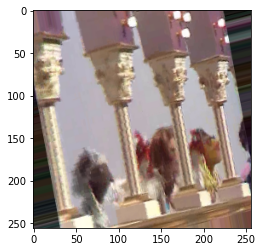

1.0


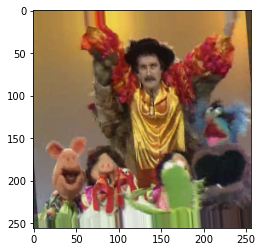

0.0


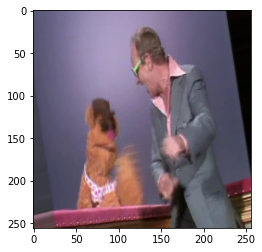

0.0


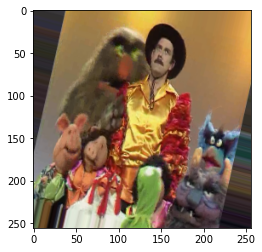

1.0


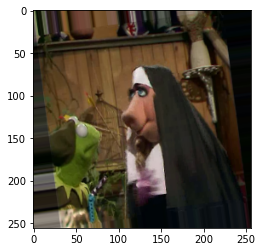

0.0


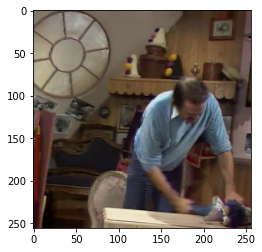

0.0


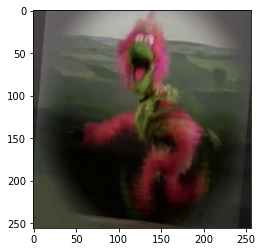

0.0


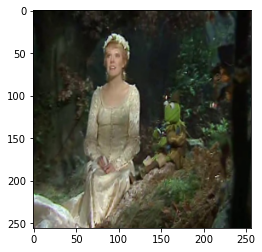

0.0


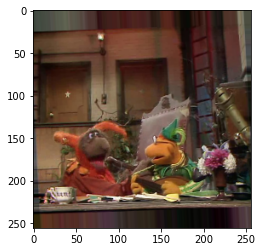

0.0


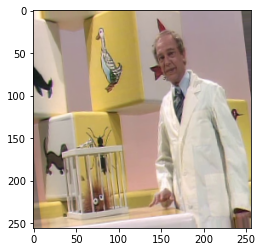

0.0


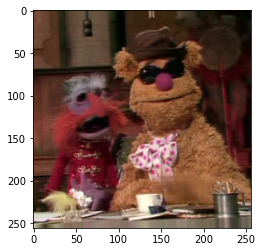

1.0


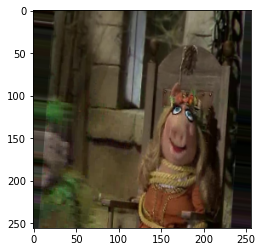

0.0


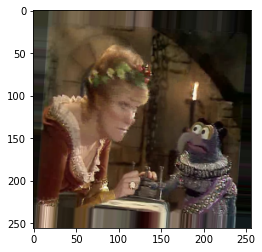

0.0


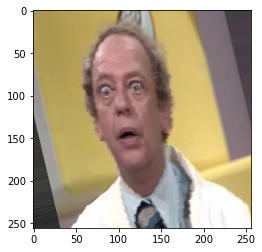

1.0


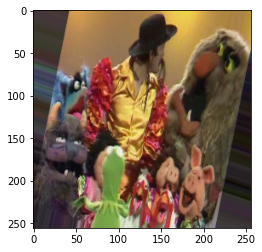

0.0


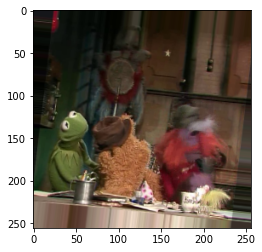

0.0


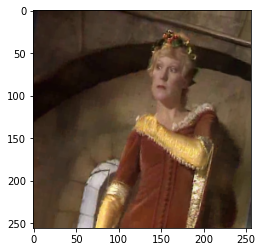

0.0


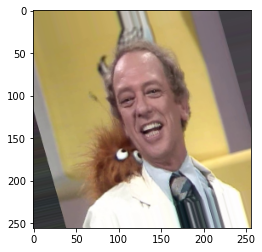

1.0


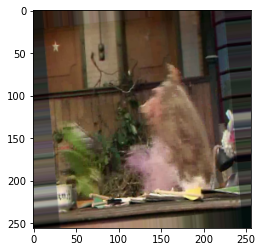

1.0


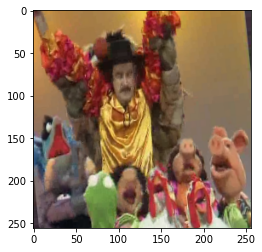

0.0


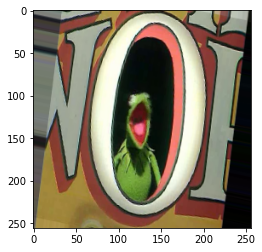

0.0


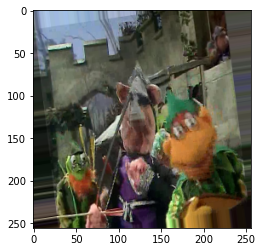

1.0


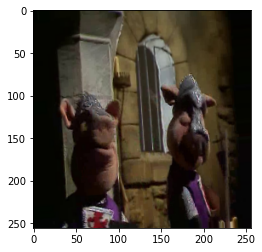

1.0


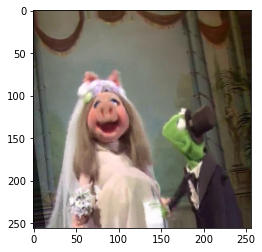

1.0


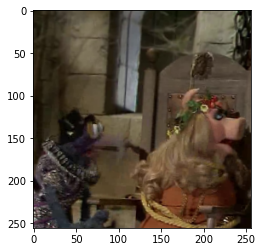

0.0


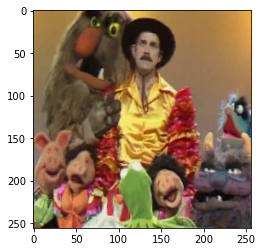

1.0


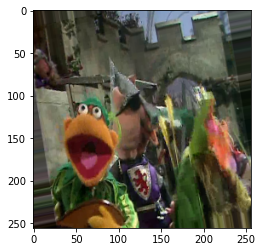

0.0


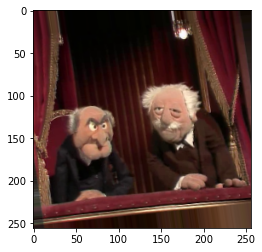

1.0


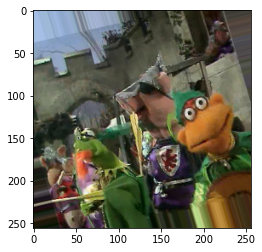

0.0


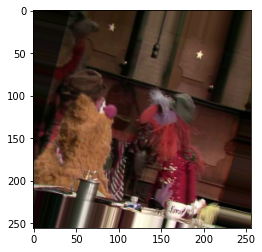

1.0


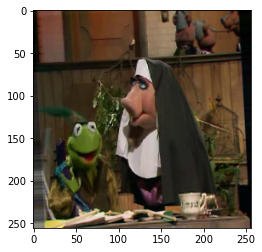

1.0


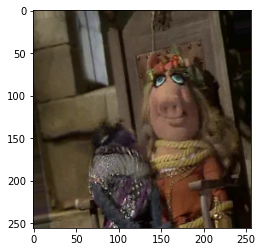

0.0


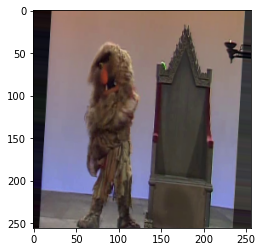

0.0


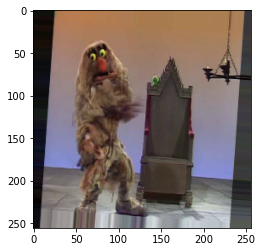

1.0


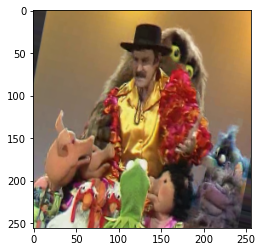

0.0


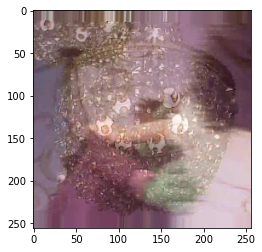

0.0


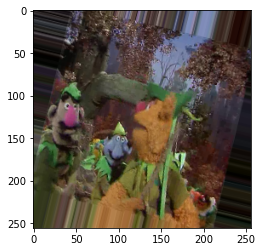

0.0


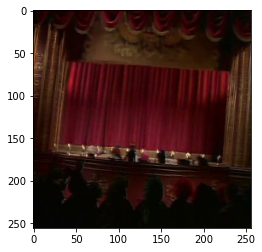

0.0


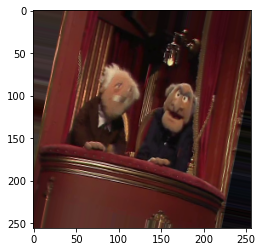

0.0


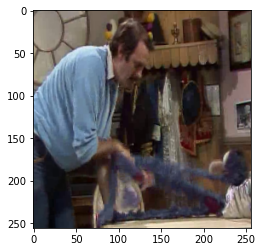

0.0


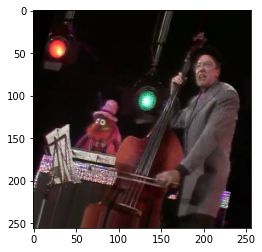

0.0


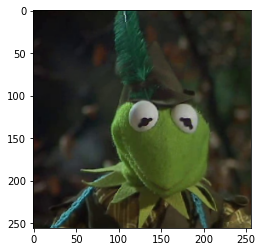

1.0


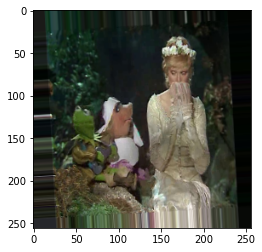

1.0


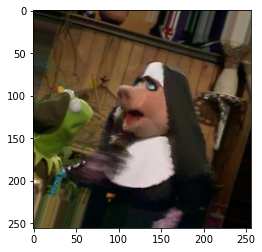

0.0


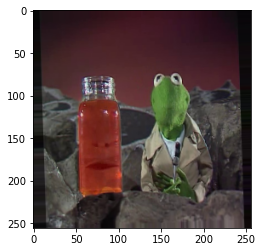

0.0


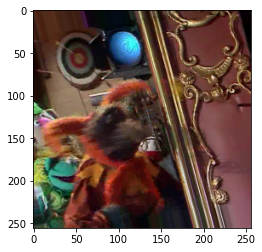

0.0


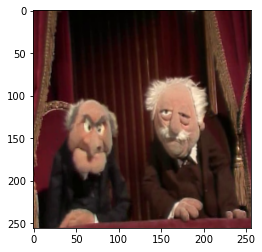

0.0


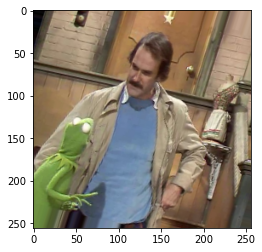

0.0


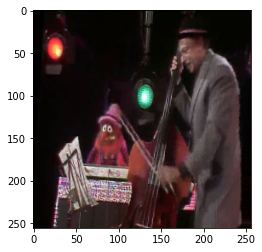

0.0


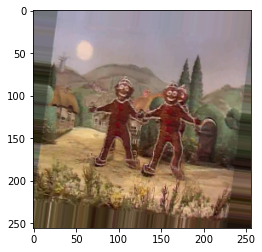

1.0


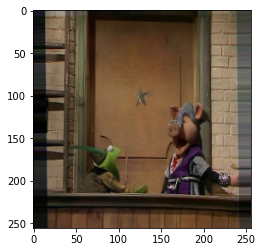

0.0


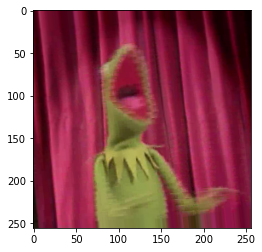

1.0


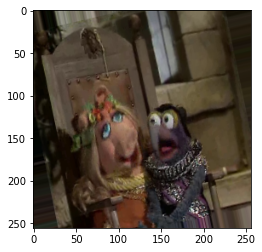

0.0


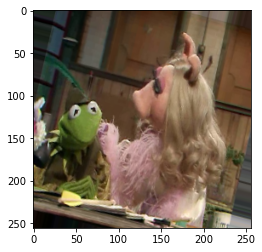

0.0


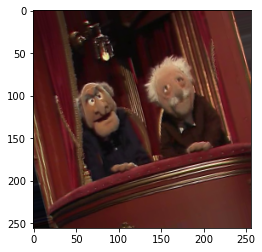

0.0


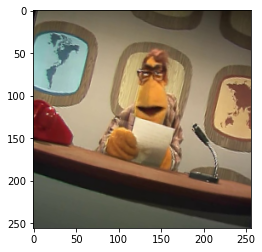

1.0


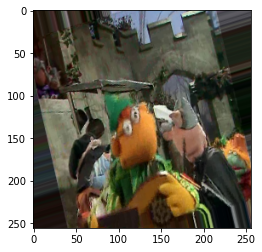

0.0


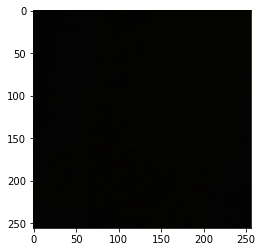

1.0


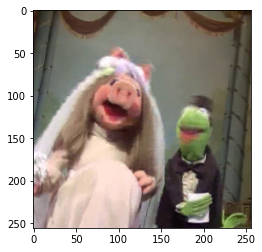

0.0


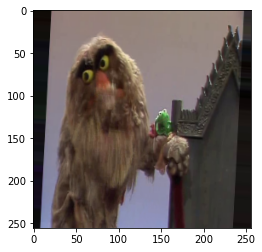

0.0


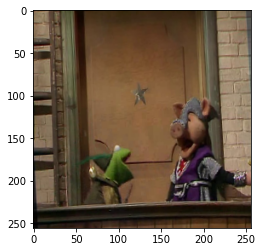

1.0


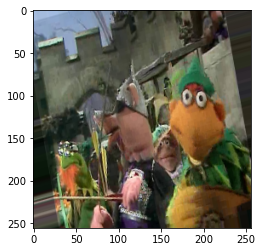

0.0


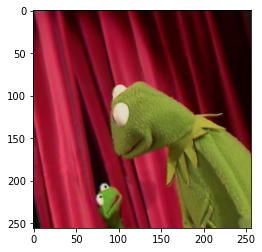

0.0


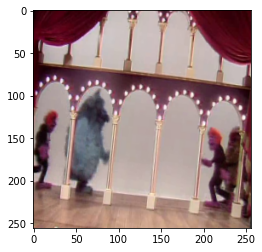

In [13]:
# Visualize images

x_batch, y_batch = next(train_pig)

for i in range (0,64):
    image = x_batch[i]
    print(y_batch[i])
    plt.imshow(image)
    plt.show()

In [ ]:
# Create the base model without top layers
vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                    include_top=False,
                                    input_shape=(256, 256, 3),
                                    pooling='max')
vgg16.summary()

flat1 = keras.layers.Flatten()(vgg16.layers[-1].output)
class1 = keras.layers.Dense(1024, activation='relu')(flat1)
output = keras.layers.Dense(1, activation='softmax')(class1)

model = keras.models.Model(inputs=vgg16.input, outputs=output)
model.summary()

# Optional: freeze VGG16 layers
#for layer in vgg16.layers:
#    layer.trainable = False
vgg16.trainable = False

model.compile(
    optimizer=keras.optimizers.SGD(0.5),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.TruePositives(), keras.metrics.FalsePositives()],
)

In [7]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(train_pig, validation_data=test_pig, epochs=3, callbacks=[cp_callback])

Epoch 1/3
39/39 [==============================] - ETA: 0s - loss: 9.5500 - binary_accuracy: 0.3737 - precision: 0.3737 - recall: 1.0000 - true_positives: 928.0000 - false_positives: 1555.0000 

KeyboardInterrupt: 

In [ ]:
model.save("model.h5")